In [119]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('Agg')
import cartopy.crs as ccrs
import h5py
import scipy
from astropy.time import Time
import utils as ut
import readers as rd
import pyproj


In [120]:
#Magic function to enable interactive plotting in Jupyter notebook
%matplotlib inline

In [121]:
data_loc='/home/jovyan/tutorial-data/sea-ice/'
fname='ATL10-01_20181115003141_07240101_002_01.h5'
fileT= data_loc+fname

In [122]:
beamStr='gt1r'
dF10 = rd.getATL10data(fileT, beam=beamStr)
dF10.head()

ATL10 file: /home/jovyan/tutorial-data/sea-ice/ATL10-01_20181115003141_07240101_002_01.h5


,freeboard,freeboard_quality,height,ssh_flag,lon,lat,delta_time,deltaTimeRel,height_segment_id,datetime,seg_x
0,0.077381,1,-0.037623,0,-168.648556,73.745906,2.747826e+07,219.501606,969,2018-11-15 00:50:58.225562,8.230003e+06
1,0.070254,1,-0.044749,0,-168.648610,73.746011,2.747826e+07,219.503267,970,2018-11-15 00:50:58.227223,8.230015e+06
2,0.029698,1,-0.085305,0,-168.648625,73.746040,2.747826e+07,219.503734,971,2018-11-15 00:50:58.227690,8.230018e+06
3,0.023347,1,-0.091656,0,-168.648647,73.746084,2.747826e+07,219.504422,972,2018-11-15 00:50:58.228379,8.230023e+06
4,0.000000,1,-0.118993,1,-168.648667,73.746124,2.747826e+07,219.505058,973,2018-11-15 00:50:58.229014,8.230028e+06


In [123]:
def create_grid(epsg_string='3413', dxRes=25000., lllat=36, llon=-90, urlat=36, urlon=90):
    """ Use pyproj to generate a grid covering the given domain (defined by the projection and the corner lat/lons)"""

    crs = pyproj.CRS.from_string("epsg:"+epsg_string)
    p=pyproj.Proj(crs)
    llcrn=p(llon, lllat)
    urcrn=p(urlon, urlat)

    print(llcrn)
    print(urcrn)

    nx = int((urcrn[0]-llcrn[0])/dxRes)+1
    ny = int((urcrn[1]-llcrn[1])/dxRes)+1
    print(nx, ny)

    x = llcrn[0]+dxRes*np.indices((ny,nx),np.float32)[0] # 1=column indicdes
    y = llcrn[1]+dxRes*np.indices((ny,nx),np.float32)[1] # 0=row indices

    lons, lats = p(x, y, inverse=True)

    return x, y, lats, lons, p

dx=25000.
xptsG, yptsG, latG, lonG, proj = create_grid(dxRes=dx)


(-4460030.963171472, -4460030.963171472)
(4460030.963171472, 4460030.963171472)
357 357


In [124]:
def bin_data(xpts, ypts, var, xptsG, yptsG, dx):
    """ Bin data using numpy histogram 2d"""

    xbins=xptsG[:,0]-(dx/2)
    ybins=yptsG[0, :]-(dx/2)
    xbins=np.append(xbins, xbins[-1]+dx)
    ybins=np.append(ybins, ybins[-1]+dx)

    counts, xedges, yedges = np.histogram2d(xpts, ypts,bins=(xbins, ybins))
    z, _, _ = np.histogram2d(xpts, ypts,bins=(xbins, ybins), weights=var)
    varG = z / counts
    
    return varG


In [125]:
# Define a projection 
mapProj = pyproj.Proj("+init=EPSG:3413")
x10, y10=mapProj(dF10.lon.values, dF10.lat.values)

varG=bin_data(x10, y10, dF10.freeboard.values, xptsG, yptsG, dx)

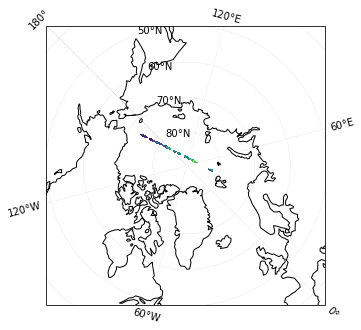

In [126]:
# Plot this gridded data
fig=plt.figure(figsize=(5, 6))
# Use the in-built northpolarstereo to vizualize (should somehow use the actual projection)
ax = plt.axes(projection =ccrs.NorthPolarStereo(central_longitude=-45))
cs=ax.pcolormesh(lonG, latG, varG, vmin=0, vmax=0.5,transform=ccrs.PlateCarree(), zorder=2)
ax.coastlines(zorder=3)
ax.gridlines(draw_labels=True,
          linewidth=0.22, color='gray', alpha=0.5, linestyle='--')

ax.set_extent([-179, 179, 50, 90], ccrs.PlateCarree())

In [127]:
# As a sanity check let's plot the raw data too...

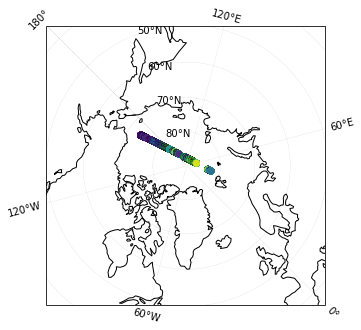

In [128]:
# Plot this gridded data
fig=plt.figure(figsize=(5, 6))
# Use the in-built northpolarstereo to vizualize (should somehow use the actual projection)
ax = plt.axes(projection =ccrs.NorthPolarStereo(central_longitude=-45))
cs=ax.scatter(dF10.lon.values, dF10.lat.values, c=dF10.freeboard.values,vmin=0, vmax=0.5,transform=ccrs.PlateCarree(), zorder=2)
ax.coastlines(zorder=3)
ax.gridlines(draw_labels=True,
          linewidth=0.22, color='gray', alpha=0.5, linestyle='--')

ax.set_extent([-179, 179, 50, 90], ccrs.PlateCarree())